# 概要
鍵ステータス情報の異常値検出がメインタスク．  
ここでは，$k$-means法により鍵ステータス情報をクラスタリングする．

## データプロット
`key_info_20181102.csv`を使用

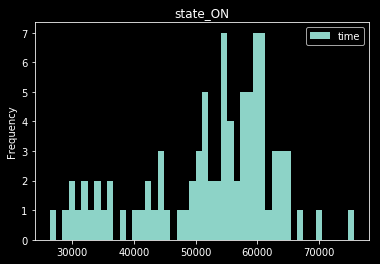

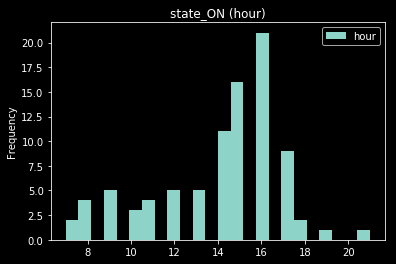

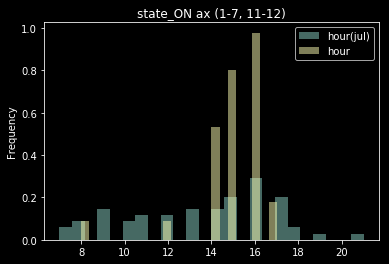

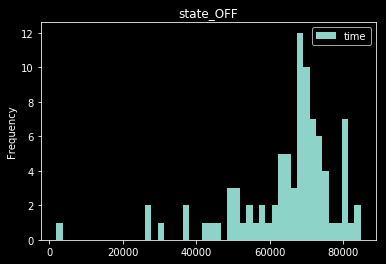

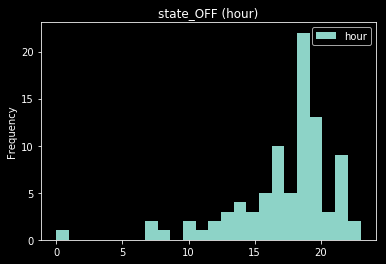

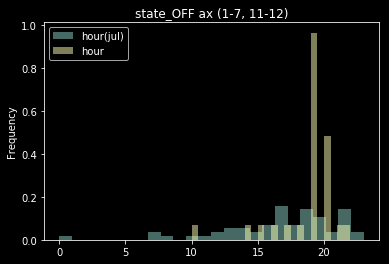

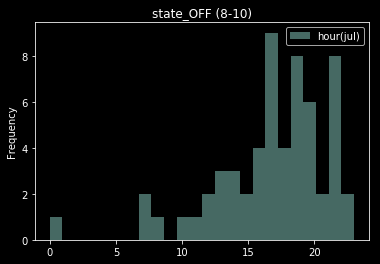

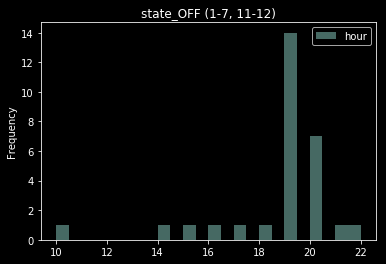

In [1]:
# coding: utf-8
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

def plot_datasets(datasets_path: str):
    # load datasets with pd
    df = pd.read_csv(datasets_path)
    
    # rename time to dtime
    df.rename(columns={'time': 'dtime'}, inplace=True)
    
    # convert dtime string to dtime format, and set to index
    df['dtime'] = pd.to_datetime(df['dtime'])
    df.set_index('dtime', inplace=True)
    
    # convert timezone to Asia/Tokyo
    df.index = df.index.tz_localize('UTC').tz_convert('Asia/Tokyo')
    
    # create time, hour, month column
    df['time'] = list(pd.Series(df.index).apply(lambda x: ((x.hour * 60 + x.minute) * 60 + x.second)))
    df['hour'] = list(pd.Series(df.index).apply(lambda x: x.hour))
    df['month'] = list(pd.Series(df.index).apply(lambda x: x.month))
    
    # convert state to int
    dummy_df = pd.get_dummies(df, columns=['state'])

    # plot hist if status is on
    dummy_df.query('state_ON == 1').plot(kind='hist', y='time', bins=48, title='state_ON')
    dummy_df.query('state_ON == 1').plot(kind='hist', y='hour', bins=24, title='state_ON (hour)')
    on_part_jul = dummy_df.query('state_ON == 1 and (month >= 8 and 10 >= month)').plot(kind='hist', y='hour', label="hour(jul)", bins=24, title='state_ON (8-10)', alpha=0.5, normed=1)
    dummy_df.query('state_ON == 1 and (month < 8 or month > 10)').plot(kind='hist', y='hour', bins=24, title='state_ON ax (1-7, 11-12)', alpha=0.5, ax=on_part_jul, normed=1)
    
    # plot hist if status is off
    dummy_df.query('state_OFF == 1').plot(kind='hist', y='time', bins=48, title='state_OFF')
    dummy_df.query('state_OFF == 1').plot(kind='hist', y='hour', bins=24, title='state_OFF (hour)')
    off_part_jul = dummy_df.query('state_OFF == 1 and (month >= 8 and 10 >= month)').plot(kind='hist', y='hour', label="hour(jul)", bins=24, title='state_OFF (8-10)', alpha=0.5, normed=1)
    dummy_df.query('state_OFF == 1 and (month >= 8 and 10 >= month)').plot(kind='hist', y='hour', label="hour(jul)", bins=24, title='state_OFF (8-10)', alpha=0.5)
    dummy_df.query('state_OFF == 1 and (month < 8 or month > 10)').plot(kind='hist', y='hour', bins=24, title='state_OFF (1-7, 11-12)', alpha=0.5)
    off_part_not_jul = dummy_df.query('state_OFF == 1 and (month < 8 or month > 10)').plot(kind='hist', y='hour', bins=24, title='state_OFF ax (1-7, 11-12)', alpha=0.5, ax=off_part_jul, normed=1)

    
def main():
    # params
    datasets_path = "./key_info_20181102_anomaly.csv"
    
    # change plt style
    plt.style.use('dark_background')

    plot_datasets(datasets_path)
    
if __name__ == "__main__":
    main()

## KDD Cup 1999(SMTP)のデータセットを用いたテスト

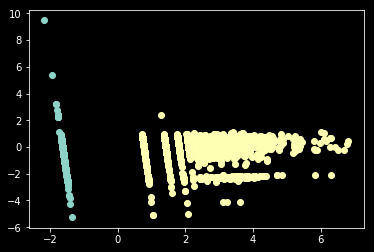

9568
3


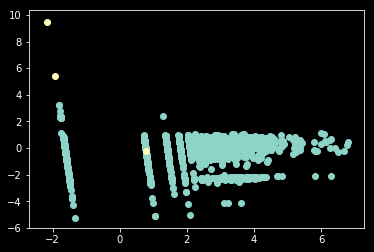

In [20]:
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_kddcup99
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# change plt style
plt.style.use('dark_background')

# load datasets
kdd_datasets = fetch_kddcup99(subset="smtp")
# dim reduction by PCA
pca = PCA(n_components=2)
X = pca.fit_transform(kdd_datasets.data)

# define cluster and calc cluster center
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

# clustering datasets
C = [[], []]
for x_part in X:
    x_part = x_part.reshape((1, x_part.shape[0]))
    C[kmeans.predict(x_part)[0]].append(x_part.tolist()[0])

# plot predict data
for c_part in C:
    if len(c_part) > 0:
        c_x, c_y = zip(*c_part)
        plt.scatter(c_x, c_y)

plt.legend()
plt.show()

# plot answer data
C_ans = [[normal_data for i, normal_data in enumerate(X) if kdd_datasets.target[i] == b'normal.'],
         [normal_data for i, normal_data in enumerate(X) if kdd_datasets.target[i] != b'normal.']]

# plot predict data
for c_part in C_ans:
    print(len(c_part))
    if len(c_part) > 0:
        c_x, c_y = zip(*c_part)
        plt.scatter(c_x, c_y)

plt.legend()
plt.show()

## ここまでの所感
$k$-meansでは異常値を適切にクラスタリングできないように思う．  
異常値がクラスタとして十分な個数まとまって存在する必要がある．